Psuedocode: 
Create a matrix of length of T/delta T by L/delta X
define a c

we have the initial 


In [1]:
R = 2 #length
nrsteps = 801 #number of segments of string

T_max = 5 #Total Time

     
delta_r = R/(nrsteps-1) #Spatial step
CFL = 0.5

using Plots
using FFTW
using JLD

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [2]:
#Radius
r_f = zeros(nrsteps, 1)
for i = 1:size(r_f,1)
    r_f[i]=(i-1)*delta_r
end

#Radius at the centers
r_c = zeros(nrsteps-1, 1)
for i = 1:size(r_c,1)
    r_c[i]=(r_f[i] + r_f[i+1])/2
end

In [3]:
#Background star
gamma = 2

#Equilibrium density at cell center
rho_zero_max=1
rho_0_c = @. rho_zero_max*sin(pi*r_c/R)/(pi*r_c/R)


#Equilibrium density at cell face
rho_0_f = @. rho_zero_max*sin(pi*r_f/R)/(pi*r_f/R)
rho_0_f[1]= rho_zero_max
#Equilibrium pessure at the cell center
p_0_c = rho_0_c.^2

#Equlibrium pressure at cell faces
p_0_f = rho_0_f.^2


801×1 Matrix{Float64}:
 1.0
 0.9999948595916105
 0.9999794384932768
 0.9999537370854961
 0.999917756002418
 0.9998714961318221
 0.9998149586150896
 0.9997481448471646
 0.9996710564765076
 0.9995836954050441
 0.9994860637880966
 0.9993781640343185
 0.999259998805612
 ⋮
 0.00019425008609854624
 0.0001601483838788802
 0.00012940504718508185
 0.00010199684281976372
 7.790051204265275e-5
 5.7092771526599364e-5
 3.955031431240243e-5
 2.5249810762415658e-5
 1.4167909512884558e-5
 6.281238424967786e-6
 1.5664055344392447e-6
 1.5195743635847466e-33

In [4]:
#Mass calculation
M_f = zeros(size(r_f,1),1)
M_f[1] = 0
for i = 2:size(r_f,1)
    M_f[i]=M_f[i-1] + (4/3)*pi*(r_f[i]^3-r_f[i-1]^3)*rho_0_c[i-1]
end

#Equilibrium Gravity 
g_0_f=M_f./(r_f.^2)
g_0_f[1] = 0

0

In [5]:
#Sound speed
c_s_squared = @. gamma*p_0_c/rho_0_c
#Timestep
delta_t=(CFL/maximum(sqrt.(c_s_squared)))*delta_r


0.0008838837604539779

In [14]:
#Initial Data
m_r = zeros(size(r_f,1), 3)
Z_r = zeros(size(r_f,1), 1)
rho_prime_c = 0*r_c;
p_prime_c = 0*r_c;

m_r[:,1]= @. sin(pi*r_f/R);
m_r[:,2]= @. sin(pi*r_f/R);

#Saving Z_r data
Z_r_list = [];
#KE_list = [];
time_list = [];
output_frequency = 10;

In [15]:
eps = 10^-10
D= zeros(nrsteps-1,nrsteps)
for i = 1:nrsteps-1
    D[i,i] = 1/(delta_r*r_c[i]^2) * (r_f[i]^2 * rho_0_f[i]);
    D[i,i+1] = -1/(delta_r*r_c[i]^2) * (r_f[i+1]^2 * rho_0_f[i+1]);
end

P= zeros(nrsteps,nrsteps-1)
for i = 2:nrsteps
    P[i,i-1] = -1/(delta_r*rho_0_f[i]) * c_s_squared[i-1] + 0.5*(g_0_f[i]/rho_0_f[i]);
    if i < nrsteps
        P[i,i] = 1/(delta_r*rho_0_f[i]) * c_s_squared[i] + 0.5*(g_0_f[i]/rho_0_f[i]);
    end
end
M=P*D
#Boundary Condition
M[1,1]=1/eps;
M[end,:] .= 0;
M[end,end-1] = (-1/eps);
M[end, end] = (1/eps)/(1+2*delta_r/r_f[end]);
M
output_frequency = 10;

In [16]:
using LinearAlgebra
lambda, V = eigen(M);
omega = sqrt.(lambda);
C = omega

801-element Vector{Float64}:
     2.5413970361597986
     3.87103069700322
     5.126273261135494
     6.353726097328241
     7.56716856539773
     8.77238382577298
     9.972225439705952
    11.168219748593755
    12.361192699037867
    13.551543854924986
    14.739366467840176
    15.924484625581522
    17.106429583415377
     ⋮
  1115.6355338771325
  1117.4679665873773
  1119.3055436462948
  1121.1495240762831
  1123.001946078022
  1124.8664566184289
  1126.7506676989256
  1128.6754753434261
  1130.7580021245412
  1244.180431825127
 99875.23388778444
 99999.99999999997

In [17]:
using IJulia
time = 0
iter = 0
anim = @animate while true
    #Boundary Conditions
    m_r[1,2] = 0
    m_r[end,2] = (rho_0_f[end]/rho_0_f[end-1])*m_r[end-1,2]/(1+2*delta_r/r_f[end])
    
    #Analysis
    Z_r[:] = @. m_r[:,2]/rho_0_f
    if iter % output_frequency == 0
        push!(Z_r_list, copy(Z_r))
        push!(time_list, time)
        #push!(KE_list, 0.5*sum(m_r .^2 .*r_f .^2 *delta_r))
        print("progress = ", time*100/T_max, "%")
        plot(r_f,Z_r[:], title = "t = $time s", ylim=(-18,18))
    end
    
    
    if time >= T_max
        break
    end
    #rho_prime
    for i=1:length(r_c)
        rho_prime_c[i] = -(1/r_c[i]^2)*(1/delta_r)*(
            (r_f[i+1]^2)*m_r[i+1,2] - (r_f[i]^2)*m_r[i,2])
    end
    p_prime_c[:]=@. rho_prime_c*c_s_squared
    
    for i=2:length(r_f)-1
        m_r[i,3]= 2*m_r[i,2]-m_r[i,1]+(delta_t^2)*((
        -(p_prime_c[i]-p_prime_c[i-1])/delta_r)-
        0.5*(rho_prime_c[i]+rho_prime_c[i-1])*g_0_f[i])
    end
    
    Z_r[:] = @. m_r[:,3]/rho_0_f
    m_r[:,1] = m_r[:,2]
    m_r[:,2] = m_r[:,3]

    time = time+delta_t
    iter = iter + 1
    
end


progress = 0.0%

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1317


progress = 0.1767767520907956%progress = 0.35355350418159126%progress = 0.5303302562723872%progress = 0.7071070083631831%progress = 0.8838837604539791%progress = 1.0606605125447748%progress = 1.2374372646355707%progress = 1.4142140167263668%progress = 1.5909907688171627%progress = 1.7677675209079584%progress = 1.9445442729987543%progress = 2.1213210250895504%progress = 2.298097777180346%progress = 2.4748745292711423%progress = 2.6516512813619384%progress = 2.8284280334527336%progress = 3.0052047855435298%progress = 3.181981537634326%progress = 3.3587582897251216%progress = 3.5355350418159177%progress = 3.7123117939067134%progress = 3.8890885459975095%progress = 4.065865298088306%progress = 4.242642050179102%progress = 4.419418802269897%progress = 4.596195554360693%progress = 4.772972306451489%progress = 4.9497490585422845%progress = 5.126525810633077%progress = 5.303302562723867%progress = 5.480079314814658%progress = 5.656856066905448%progress = 5.833632818996238%progress = 6.01040957

progress = 49.497490585422625%progress = 49.67426733751345%progress = 49.85104408960427%progress = 50.02782084169509%progress = 50.20459759378592%progress = 50.38137434587674%progress = 50.55815109796757%progress = 50.734927850058384%progress = 50.911704602149214%progress = 51.08848135424004%progress = 51.26525810633086%progress = 51.442034858421685%progress = 51.61881161051251%progress = 51.795588362603326%progress = 51.97236511469415%progress = 52.14914186678497%progress = 52.325918618875804%progress = 52.50269537096663%progress = 52.67947212305745%progress = 52.856248875148275%progress = 53.0330256272391%progress = 53.209802379329915%progress = 53.38657913142074%progress = 53.56335588351156%progress = 53.74013263560239%progress = 53.91690938769322%progress = 54.09368613978404%progress = 54.270462891874864%progress = 54.44723964396569%progress = 54.624016396056504%progress = 54.80079314814733%progress = 54.97756990023815%progress = 55.15434665232898%progress = 55.331123404419806%prog

progress = 99.70208817921653%progress = 99.87886493130736%

Animation("C:\\Users\\tom37\\AppData\\Local\\Temp\\jl_Ou6BtL", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "005648.png", "005649.png", "005650.png", "005651.png", "005652.png", "005653.png", "005654.png", "005655.png", "005656.png", "005657.png"])

In [19]:
test=Z_r_list;
save("polytrope2.jld","Z_r",Z_r_list, "time", time_list,  "Radius at faces", r_f, "Radius at centers", r_c, "delta_t", delta_t)
save("omega.jld", "omega_list", C)

┌ Info: Saved animation to 
│   fn = C:\Users\tom37\anim_fps1.gif
└ @ Plots C:\Users\tom37\.julia\packages\Plots\QaOSg\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\tom37\\anim_fps1.gif")
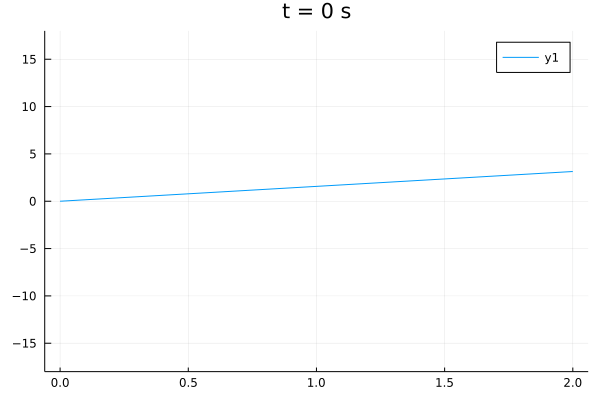

In [20]:
gif(anim, "anim_fps1.gif",fps=60)
#Next step make a movie using plot
